In [1]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# TensorFlow and tf.keras
# import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import urllib3

import tensorflow_datasets as tfds

In [3]:
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


# Input Normalization

In [3]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [4]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

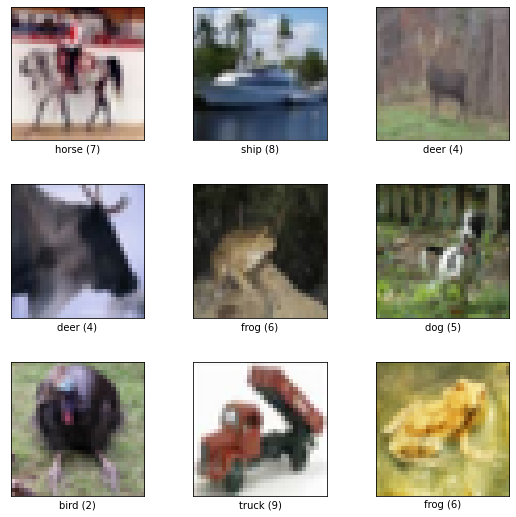

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

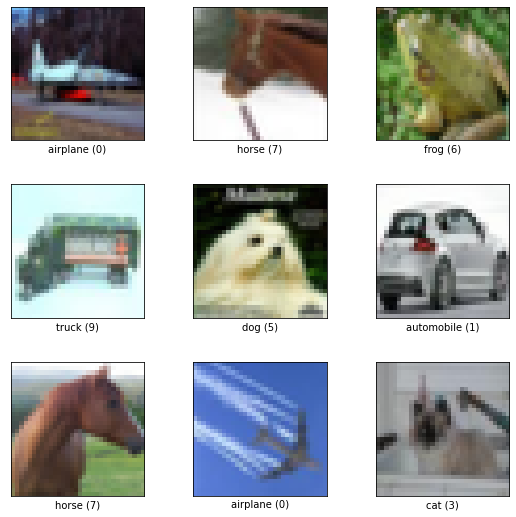

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

# CIFAR-10 데이터셋 학습 (ResNet34, 50)

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D, Add, Activation, BatchNormalization, Dropout

In [13]:
BATCH_SIZE = 32
EPOCH = 50

# checkpoint_dir = './models/'

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [14]:
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
#                                                 save_weights_only=True,
#                                                 monitor='val_loss',
#                                                 mode='auto',
#                                                 save_best_only=True,
#                                                 verbose=1)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./models/best_at_{epoch}.h5', monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# ResNet 기본 블록 구성

- ResNet34

In [4]:
from tensorflow.keras import layers

In [5]:
def build_resnet_residual(x, channel, kernel_size=3, stride=1, conv_shortcut=False, is_plain=False):
    # skip-connection
    if conv_shortcut:
        shortcut = layers.Conv2D(channel, 1, strides=stride, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    else:
        shortcut = x     
    
    # CNN layer
    if conv_shortcut:
        x1 = layers.Conv2D(filters=channel, kernel_size=3, strides=2, padding='same')(x)
    else:
        x1 = layers.Conv2D(channel, 3, strides=1, padding='same')(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)

    x1 = layers.Conv2D(channel, 3, strides=1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    
    if is_plain:
        x1 = layers.ReLU()(x1)
        return x1
    else:
        x = layers.Add()([x1, shortcut])
        x = layers.ReLU()(x)
        return x

In [6]:
def build_resnet_bottleneck(x, channel, kernel_size=3, stride=1, conv_shortcut=False, is_plain=False):
    # skip-connection
    if conv_shortcut:
        shortcut = layers.Conv2D(channel * 4, 1, strides=stride, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    else:
        shortcut = x
    
    # CNN layer
    if conv_shortcut:
        x1 = layers.Conv2D(channel, 1, strides=stride, padding='same')(x)
    else:
        x1 = layers.Conv2D(channel, 1, strides=1, padding='same')(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)

    x1 = layers.Conv2D(channel, 3, strides=1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)
    
    x1 = layers.Conv2D(channel * 4, 1, strides=1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    
    if is_plain:
        x1 = layers.ReLU()(x1)
        return x1
    else:
        x = layers.Add()([x1, shortcut])
        x = layers.ReLU()(x)
        return x

In [7]:
def build_resnet_blocks(input_layer, 
                        num_cnn=3, 
                        channel=64, 
                        strides=1,
                        block_num=0, 
                        is_plain=False, 
                        is_50=False):
    # input layer
    x = input_layer
    if is_50:
        for i in range(num_cnn):
            if block_num == 2 and i == 0:
                x = build_resnet_bottleneck(x, channel, conv_shortcut=True, is_plain=is_plain)
            elif block_num != 2 and i == 0:
                x = build_resnet_bottleneck(x, channel, stride=2, conv_shortcut=True, is_plain=is_plain)
            else:
                x = build_resnet_bottleneck(x, channel, is_plain=is_plain)
    else:
        for i in range(num_cnn):
            if block_num != 2 and i == 0:
                x = build_resnet_residual(x, channel, stride=2, conv_shortcut=True, is_plain=is_plain)
            else:
                x = build_resnet_residual(x, channel, is_plain=is_plain)
        
    return x


In [8]:
def build_resnet(input_shape=(224, 224, 3), 
                 num_cnn_list=[3, 4, 6, 3], 
                 channel_list=[64, 128, 256, 512], 
                 num_classes=10, 
                 is_plain=False, 
                 is_50=False):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = layers.Input(shape=input_shape)
    output = input_layer
    
    # conv1
    output = layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', name='conv1')(output)
    output = layers.BatchNormalization()(output)
    output = layers.ReLU()(output)
    output = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same', name='conv2_maxpool2d')(output)
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_blocks(output, 
                                    num_cnn=num_cnn, 
                                    channel=channel, 
                                    block_num=i+2,
                                    is_plain=is_plain,
                                    is_50=is_50)
        
    output = keras.layers.GlobalAveragePooling2D(name='average_pooling')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    
    return model

In [9]:
resnet34 = build_resnet(input_shape=(32, 32, 3), num_classes=10) # binary -> num_classes=2

In [22]:
resnet34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [23]:
# tf.keras.utils.plot_model(resnet34, show_shapes=True, dpi=64)

In [24]:
resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es, mc]
)

Epoch 1/50
1562/1562 [==============================] - 78s 39ms/step - loss: 2.3930 - accuracy: 0.2355 - val_loss: 1.8701 - val_accuracy: 0.3692

Epoch 00001: val_loss improved from inf to 1.87013, saving model to ./models/best_at_1.h5
Epoch 2/50
1562/1562 [==============================] - 46s 29ms/step - loss: 1.5814 - accuracy: 0.4313 - val_loss: 1.3618 - val_accuracy: 0.4988

Epoch 00002: val_loss improved from 1.87013 to 1.36176, saving model to ./models/best_at_2.h5
Epoch 3/50
1562/1562 [==============================] - 46s 30ms/step - loss: 1.3083 - accuracy: 0.5307 - val_loss: 1.2765 - val_accuracy: 0.5456

Epoch 00003: val_loss improved from 1.36176 to 1.27649, saving model to ./models/best_at_3.h5
Epoch 4/50
1562/1562 [==============================] - 47s 30ms/step - loss: 1.1071 - accuracy: 0.6101 - val_loss: 1.2414 - val_accuracy: 0.5647

Epoch 00004: val_loss improved from 1.27649 to 1.24138, saving model to ./models/best_at_4.h5
Epoch 5/50
1562/1562 [==================

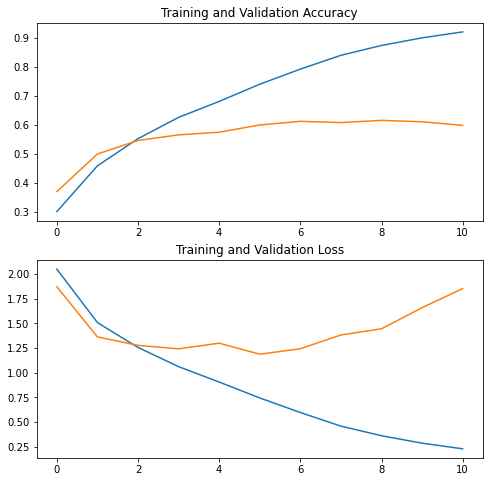

In [26]:
# history for acc and loss graph
import matplotlib.pyplot as plt

acc = history_34.history['accuracy']
val_acc = history_34.history['val_accuracy']

loss = history_34.history['loss']
val_loss = history_34.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
resnet34.save('./models/res34_CIFAR10_e10.h5')

- ResNet-50

In [38]:
resnet50 = build_resnet(input_shape=(32, 32, 3), is_50=True, num_classes=10)

In [30]:
resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu_33 (ReLU)                 (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

In [31]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es, mc]
)

Epoch 1/50
1562/1562 [==============================] - 98s 46ms/step - loss: 2.9201 - accuracy: 0.1351 - val_loss: 2.9772 - val_accuracy: 0.1891


Epoch 2/50
1562/1562 [==============================] - 52s 33ms/step - loss: 2.3008 - accuracy: 0.2031 - val_loss: 2.3161 - val_accuracy: 0.2735


Epoch 3/50
1562/1562 [==============================] - 53s 34ms/step - loss: 2.0400 - accuracy: 0.2774 - val_loss: 2.2662 - val_accuracy: 0.3180


Epoch 4/50
1562/1562 [==============================] - 53s 34ms/step - loss: 1.8149 - accuracy: 0.3467 - val_loss: 1.6534 - val_accuracy: 0.4006


Epoch 5/50
1562/1562 [==============================] - 53s 34ms/step - loss: 1.5988 - accuracy: 0.4261 - val_loss: 1.5563 - val_accuracy: 0.4430


Epoch 6/50
1562/1562 [==============================] - 53s 34ms/step - loss: 1.4471 - accuracy: 0.4823 - val_loss: 1.3844 - val_accuracy: 0.5013


Epoch 7/50
1562/1562 [==============================] - 53s 34ms/step - loss: 1.3065 - accuracy: 0.5372 - val_loss: 1.2976 - val_accuracy: 0.5386


Epoch 8/50
1562/1562 [==============================] - 53s 34ms/step - loss: 1.1509 - accuracy: 0.5953 - val_loss: 1.3323 - val_accuracy: 0.5448


Epoch 9/50
1562/1562 [==============================] - 53s 34ms/step - loss: 1.0153 - accuracy: 0.6416 - val_loss: 1.3051 - val_accuracy: 0.5617


Epoch 10/50
1562/1562 [==============================] - 53s 34ms/step - loss: 0.8408 - accuracy: 0.7066 - val_loss: 1.3082 - val_accuracy: 0.5751


Epoch 11/50
1562/1562 [==============================] - 53s 34ms/step - loss: 0.6871 - accuracy: 0.7604 - val_loss: 1.4478 - val_accuracy: 0.5718


Epoch 12/50
1562/1562 [==============================] - 53s 34ms/step - loss: 0.5507 - accuracy: 0.8083 - val_loss: 1.6647 - val_accuracy: 0.5582


Epoch 00012: early stopping


In [42]:
resnet50.save('./models/res50_CIFAR10_e12.h5')

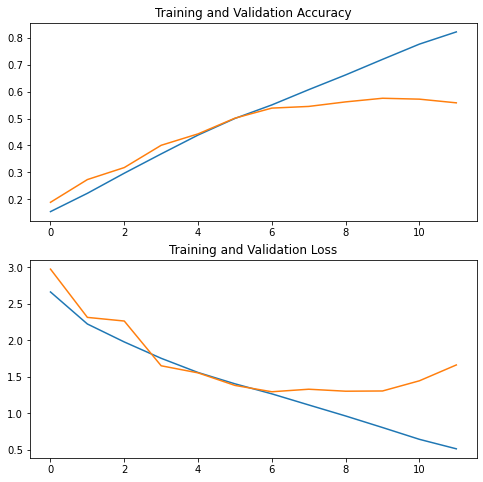

In [33]:
# history for acc and loss graph
acc = history_50.history['accuracy']
val_acc = history_50.history['val_accuracy']

loss = history_50.history['loss']
val_loss = history_50.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

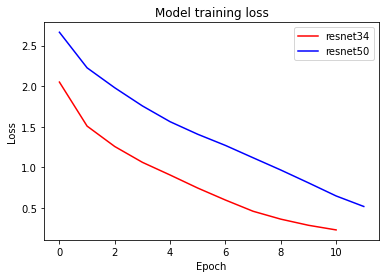

In [34]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50'], loc='upper right')
plt.show()

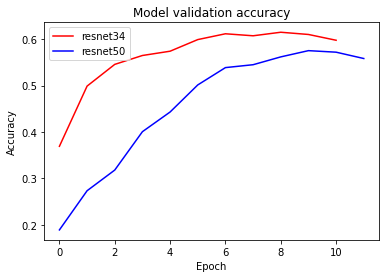

In [35]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50'], loc='upper left')
plt.show()

- resnet152

In [40]:
resnet152 = build_resnet(input_shape=(32, 32, 3), is_50=True, num_cnn_list=[3, 8, 36, 3], num_classes=10)
resnet152.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_248 (BatchN (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu_229 (ReLU)                (None, 16, 16, 64)   0           batch_normalization_248[0][0]    
____________________________________________________________________________________________

In [41]:
resnet152.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_152 = resnet152.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es, mc]
)

Epoch 1/50
1562/1562 [==============================] - 152s 84ms/step - loss: 2.9117 - accuracy: 0.1174 - val_loss: 3.4664 - val_accuracy: 0.1200


Epoch 2/50
1562/1562 [==============================] - 130s 83ms/step - loss: 2.4912 - accuracy: 0.1315 - val_loss: 5.0300 - val_accuracy: 0.1431


Epoch 3/50
1562/1562 [==============================] - 131s 84ms/step - loss: 2.2511 - accuracy: 0.1822 - val_loss: 2.6198 - val_accuracy: 0.2383


Epoch 4/50
1562/1562 [==============================] - 131s 84ms/step - loss: 1.9768 - accuracy: 0.2857 - val_loss: 1.9785 - val_accuracy: 0.3524


Epoch 5/50
1562/1562 [==============================] - 133s 85ms/step - loss: 1.7487 - accuracy: 0.3712 - val_loss: 1.5738 - val_accuracy: 0.4351


Epoch 6/50
1562/1562 [==============================] - 132s 84ms/step - loss: 1.5822 - accuracy: 0.4324 - val_loss: 1.5165 - val_accuracy: 0.4502


Epoch 7/50
1562/1562 [==============================] - 131s 84ms/step - loss: 1.4427 - accuracy: 0.4887 - val_loss: 1.9914 - val_accuracy: 0.4003


Epoch 8/50
1562/1562 [==============================] - 131s 84ms/step - loss: 1.3201 - accuracy: 0.5358 - val_loss: 1.2954 - val_accuracy: 0.5492


Epoch 9/50
1562/1562 [==============================] - 131s 84ms/step - loss: 1.1824 - accuracy: 0.5895 - val_loss: 1.3945 - val_accuracy: 0.5375


Epoch 10/50
1562/1562 [==============================] - 131s 84ms/step - loss: 1.0598 - accuracy: 0.6330 - val_loss: 1.3429 - val_accuracy: 0.5474


Epoch 11/50
1562/1562 [==============================] - 131s 84ms/step - loss: 0.9219 - accuracy: 0.6814 - val_loss: 1.5943 - val_accuracy: 0.5275


Epoch 12/50
1562/1562 [==============================] - 131s 84ms/step - loss: 0.7989 - accuracy: 0.7257 - val_loss: 1.3811 - val_accuracy: 0.5639


Epoch 13/50
1562/1562 [==============================] - 131s 84ms/step - loss: 0.6705 - accuracy: 0.7711 - val_loss: 1.7881 - val_accuracy: 0.5580


Epoch 00013: early stopping


In [43]:
resnet152.save('./models/res152_CIFAR12_e.h5')

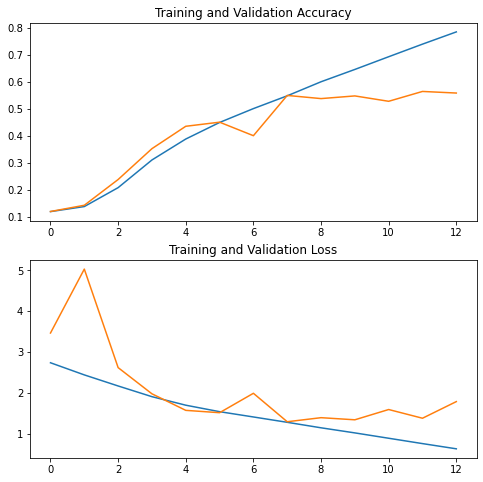

In [44]:
# history for acc and loss graph
acc = history_152.history['accuracy']
val_acc = history_152.history['val_accuracy']

loss = history_152.history['loss']
val_loss = history_152.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

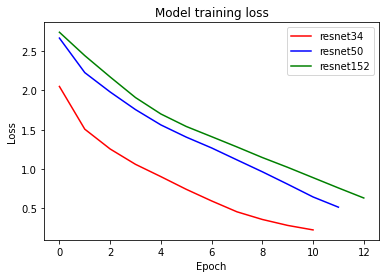

In [46]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.plot(history_152.history['loss'], 'g')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50', 'resnet152'], loc='upper right')
plt.show()

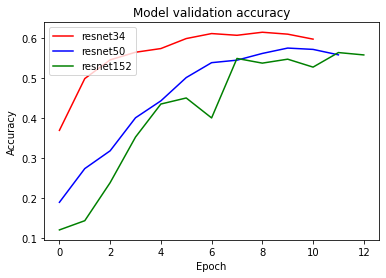

In [47]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.plot(history_152.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet50', 'resnet152'], loc='upper left')
plt.show()

# cats and dogs Dataset

In [12]:
# cats vs dogs 데이터셋
# https://east-rain.github.io/docs/Deep%20Learning/tensorflow%20tutorial/image_transfer_learning_preTrained.html

urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
    shuffle_files=True,
)

In [13]:
BATCH_SIZE = 32
EPOCH = 20

In [14]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [15]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [16]:
len_train = tf.constant(tf.data.experimental.cardinality(ds_train)).numpy()
len_test = tf.constant(tf.data.experimental.cardinality(ds_test)).numpy()

print(len_train)
print(len_test)

18610
4652


In [17]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [18]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [19]:
ds_info.features["label"].num_classes

2

In [20]:
ds_info.features["label"].names

['cat', 'dog']

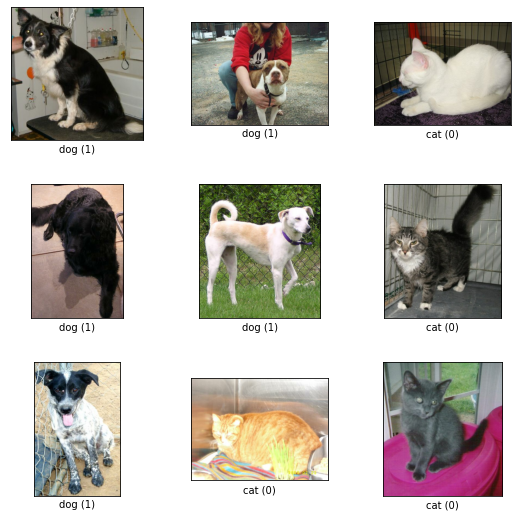

In [21]:
fig = tfds.show_examples(ds_train, ds_info)

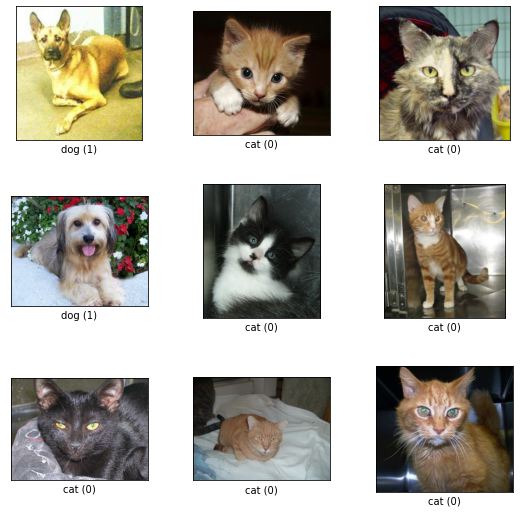

In [22]:
fig = tfds.show_examples(ds_test, ds_info)

In [23]:
ds_train = apply_normalize_on_dataset(ds_train, is_test=False, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, is_test=False, batch_size=BATCH_SIZE)

In [24]:
print(len_train)
print(len_test)

18610
4652


In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./models/best_at_{epoch}.h5', monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

In [25]:
resnet34 = build_resnet(input_shape=(224, 224, 3), num_classes=2) # binary -> num_classes=2

In [26]:
resnet34.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_34 = resnet34.fit(
    ds_train,
    steps_per_epoch=int(len_train/BATCH_SIZE),
    validation_steps=int(len_test/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[es, mc],
)

Epoch 1/20
581/581 [==============================] - 122s 178ms/step - loss: 0.8139 - accuracy: 0.5813 - val_loss: 0.6905 - val_accuracy: 0.5061


Epoch 2/20
581/581 [==============================] - 87s 150ms/step - loss: 0.5891 - accuracy: 0.6983 - val_loss: 0.6131 - val_accuracy: 0.6574


Epoch 3/20
581/581 [==============================] - 87s 150ms/step - loss: 0.4961 - accuracy: 0.7657 - val_loss: 0.5566 - val_accuracy: 0.7407


Epoch 4/20
581/581 [==============================] - 88s 151ms/step - loss: 0.4280 - accuracy: 0.8051 - val_loss: 0.8490 - val_accuracy: 0.7139


Epoch 5/20
581/581 [==============================] - 88s 151ms/step - loss: 0.3379 - accuracy: 0.8544 - val_loss: 0.4937 - val_accuracy: 0.8039


Epoch 6/20
581/581 [==============================] - 88s 151ms/step - loss: 0.2839 - accuracy: 0.8782 - val_loss: 0.5818 - val_accuracy: 0.8080


Epoch 7/20
581/581 [==============================] - 89s 153ms/step - loss: 0.2397 - accuracy: 0.8964 - val_loss: 0.3146 - val_accuracy: 0.8602


Epoch 8/20
581/581 [==============================] - 88s 152ms/step - loss: 0.2060 - accuracy: 0.9135 - val_loss: 0.3454 - val_accuracy: 0.8648


Epoch 9/20
581/581 [==============================] - 88s 152ms/step - loss: 0.1877 - accuracy: 0.9221 - val_loss: 0.3074 - val_accuracy: 0.8667


Epoch 10/20
581/581 [==============================] - 88s 152ms/step - loss: 0.1660 - accuracy: 0.9332 - val_loss: 0.2039 - val_accuracy: 0.9209


Epoch 11/20
581/581 [==============================] - 89s 153ms/step - loss: 0.1386 - accuracy: 0.9452 - val_loss: 0.3108 - val_accuracy: 0.8683


Epoch 12/20
581/581 [==============================] - 91s 156ms/step - loss: 0.1227 - accuracy: 0.9500 - val_loss: 0.2484 - val_accuracy: 0.9013


Epoch 13/20
581/581 [==============================] - 89s 153ms/step - loss: 0.1192 - accuracy: 0.9534 - val_loss: 0.3190 - val_accuracy: 0.8881


Epoch 14/20
581/581 [==============================] - 89s 153ms/step - loss: 0.0946 - accuracy: 0.9607 - val_loss: 0.1859 - val_accuracy: 0.9275


Epoch 15/20
581/581 [==============================] - 90s 155ms/step - loss: 0.0773 - accuracy: 0.9700 - val_loss: 0.2153 - val_accuracy: 0.9166


Epoch 16/20
581/581 [==============================] - 94s 162ms/step - loss: 0.0750 - accuracy: 0.9719 - val_loss: 0.2562 - val_accuracy: 0.9054


Epoch 17/20
581/581 [==============================] - 87s 150ms/step - loss: 0.0622 - accuracy: 0.9748 - val_loss: 0.2302 - val_accuracy: 0.9137


Epoch 18/20
581/581 [==============================] - 83s 142ms/step - loss: 0.0622 - accuracy: 0.9752 - val_loss: 0.2438 - val_accuracy: 0.9154


Epoch 19/20
581/581 [==============================] - 83s 142ms/step - loss: 0.0428 - accuracy: 0.9839 - val_loss: 0.2909 - val_accuracy: 0.9143


Epoch 00019: early stopping


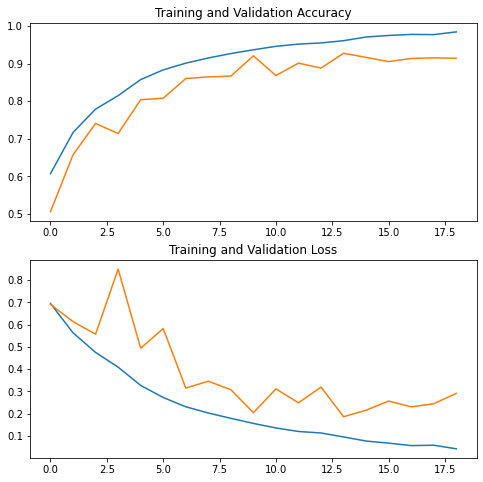

In [28]:
# history for acc and loss graph
acc = history_34.history['accuracy']
val_acc = history_34.history['val_accuracy']

loss = history_34.history['loss']
val_loss = history_34.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
resnet50 = build_resnet(input_shape=(224, 224, 3), is_50=True, num_classes=2) # binary -> num_classes=2

In [30]:
resnet50.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(len_train/BATCH_SIZE),
    validation_steps=int(len_test/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[es, mc],
)

Epoch 1/20
581/581 [==============================] - 212s 310ms/step - loss: 0.9089 - accuracy: 0.5757 - val_loss: 5.5410 - val_accuracy: 0.5439


Epoch 2/20
581/581 [==============================] - 144s 249ms/step - loss: 0.6062 - accuracy: 0.6753 - val_loss: 2.1214 - val_accuracy: 0.5188


Epoch 3/20
581/581 [==============================] - 145s 250ms/step - loss: 0.5351 - accuracy: 0.7329 - val_loss: 0.6442 - val_accuracy: 0.6627


Epoch 4/20
581/581 [==============================] - 145s 249ms/step - loss: 0.4758 - accuracy: 0.7738 - val_loss: 0.8118 - val_accuracy: 0.6760


Epoch 5/20
581/581 [==============================] - 146s 251ms/step - loss: 0.4380 - accuracy: 0.8016 - val_loss: 1.0602 - val_accuracy: 0.6704


Epoch 6/20
581/581 [==============================] - 146s 251ms/step - loss: 0.3661 - accuracy: 0.8443 - val_loss: 1.1357 - val_accuracy: 0.6284


Epoch 7/20
581/581 [==============================] - 145s 249ms/step - loss: 0.3174 - accuracy: 0.8680 - val_loss: 1.0057 - val_accuracy: 0.5217


Epoch 8/20
581/581 [==============================] - 146s 251ms/step - loss: 0.2752 - accuracy: 0.8786 - val_loss: 0.3380 - val_accuracy: 0.8433


Epoch 9/20
581/581 [==============================] - 145s 250ms/step - loss: 0.2236 - accuracy: 0.9087 - val_loss: 0.3972 - val_accuracy: 0.8110


Epoch 10/20
581/581 [==============================] - 145s 250ms/step - loss: 0.1940 - accuracy: 0.9198 - val_loss: 0.3036 - val_accuracy: 0.8651


Epoch 11/20
581/581 [==============================] - 145s 249ms/step - loss: 0.1696 - accuracy: 0.9327 - val_loss: 0.2844 - val_accuracy: 0.8881


Epoch 12/20
581/581 [==============================] - 146s 252ms/step - loss: 0.1680 - accuracy: 0.9290 - val_loss: 0.5013 - val_accuracy: 0.7716


Epoch 13/20
581/581 [==============================] - 145s 250ms/step - loss: 0.1550 - accuracy: 0.9376 - val_loss: 0.5251 - val_accuracy: 0.8461


Epoch 14/20
581/581 [==============================] - 146s 250ms/step - loss: 0.1295 - accuracy: 0.9483 - val_loss: 0.3016 - val_accuracy: 0.9013


Epoch 15/20
581/581 [==============================] - 145s 249ms/step - loss: 0.1392 - accuracy: 0.9442 - val_loss: 0.2483 - val_accuracy: 0.9030


Epoch 16/20
581/581 [==============================] - 145s 250ms/step - loss: 0.1067 - accuracy: 0.9589 - val_loss: 0.2853 - val_accuracy: 0.9080


Epoch 17/20
581/581 [==============================] - 145s 250ms/step - loss: 0.0893 - accuracy: 0.9642 - val_loss: 0.2050 - val_accuracy: 0.9245


Epoch 18/20
581/581 [==============================] - 147s 253ms/step - loss: 0.0877 - accuracy: 0.9642 - val_loss: 0.1937 - val_accuracy: 0.9213


Epoch 19/20
581/581 [==============================] - 145s 250ms/step - loss: 0.0791 - accuracy: 0.9693 - val_loss: 0.2871 - val_accuracy: 0.8879


Epoch 20/20
581/581 [==============================] - 148s 255ms/step - loss: 0.0713 - accuracy: 0.9734 - val_loss: 0.4853 - val_accuracy: 0.8245


In [33]:
# 더 떨어질 기미가 보여서 추가 학습 진행
resnet50.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(len_train/BATCH_SIZE),
    validation_steps=int(len_test/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[es, mc],
)

Epoch 1/20
581/581 [==============================] - 153s 251ms/step - loss: 0.0641 - accuracy: 0.9753 - val_loss: 0.3211 - val_accuracy: 0.8748

Epoch 00001: val_accuracy improved from -inf to 0.87478, saving model to ./models/best_at_1.h5
Epoch 2/20
581/581 [==============================] - 146s 251ms/step - loss: 0.0547 - accuracy: 0.9784 - val_loss: 0.2416 - val_accuracy: 0.9163

Epoch 00002: val_accuracy improved from 0.87478 to 0.91630, saving model to ./models/best_at_2.h5
Epoch 3/20
581/581 [==============================] - 149s 257ms/step - loss: 0.0507 - accuracy: 0.9819 - val_loss: 0.2188 - val_accuracy: 0.9271

Epoch 00003: val_accuracy improved from 0.91630 to 0.92706, saving model to ./models/best_at_3.h5
Epoch 4/20
581/581 [==============================] - 148s 255ms/step - loss: 0.0463 - accuracy: 0.9829 - val_loss: 0.2666 - val_accuracy: 0.9141

Epoch 00004: val_accuracy did not improve from 0.92706
Epoch 5/20
581/581 [==============================] - 149s 256ms/s

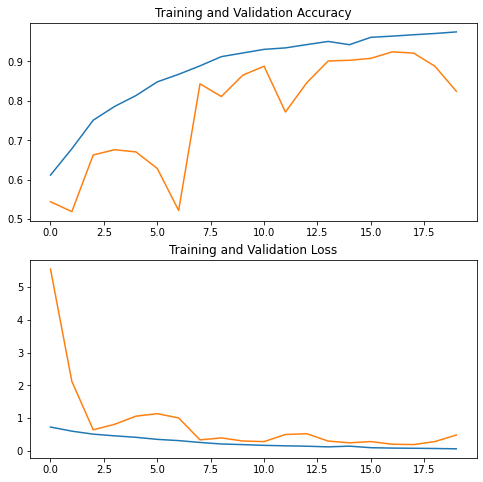

In [32]:
# history for acc and loss graph
acc = history_50.history['accuracy']
val_acc = history_50.history['val_accuracy']

loss = history_50.history['loss']
val_loss = history_50.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
resnet152 = build_resnet(input_shape=(224, 224, 3), is_50=True, num_cnn_list=[3, 8, 36, 3], num_classes=2)
resnet152.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [28]:
BATCH_SIZE=16 # OOM Issue

In [ ]:
resnet152.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_152 = resnet152.fit(
    ds_train,
    steps_per_epoch=int(len_train/BATCH_SIZE),
    validation_steps=int(len_test/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[es, mc],
)

Epoch 1/20


In [ ]:
# history for acc and loss graph
acc = history_152.history['accuracy']
val_acc = history_152.history['val_accuracy']

loss = history_152.history['loss']
val_loss = history_152.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()